In [1]:
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def cov(x, y):
    #definition of cov(x, y) = E[xy] - E[x]E[y]
    return np.mean(x * y) - np.mean(x) * np.mean(y)

def corr(x, y):
    #corr(x, y) = cov(x, y) / sqrt(var(x) * var(y))
    #var(y) == 0 --> this edge case is checked in the decision tree algorithm
    #var(y) == 0 --> implies very high correlation in that set of data
    #var(x) == 0 --> implies very low correlation in that set of data (hence we return 0 on this)
    if np.var(x) == 0:
        return 0
    return cov(x, y) / math.sqrt(np.var(x) * np.var(y))

def generate_data(size, d):
    x = []
    x.append(np.random.normal(3, 1, size))
    x.append(np.random.normal(-2, 1, size))
    x.append(x[0] + 2 * x[1])
    x.append((x[1] + 2)**2)
    x.append(np.random.binomial(n=1, p=0.8, size=size))
    for _ in range(d - 5):
        x.append(np.random.normal(0, 0.1, size))

    def compute_y(x):
        y = 4 - 3 * x[0] * x[0] + x[2] - 0.01 * x[3] + x[1] * x[4] + np.random.normal(0, 0.1, len(x[0]))
        return y
    
    def transpose(temp):
        temp = np.array(temp)
        return temp.T
    
    xt = transpose(x)
    y = compute_y(x)
    
    return x, xt, y

In [7]:
class DecisionTree():   
    def __init__(self, x, y, d, max_depth, min_sample_size):
        self.x = x
        self.y = y
        
        self.max_depth = max_depth
        self.min_sample_size = min_sample_size
        self.depth = d 
        self.child = len(self.x[0]) <= self.min_sample_size or self.depth == self.max_depth or np.var(y) == 0
        
        self.ind = -1
        self.threshold = 0
        
        self.result = np.mean(y)
        self.left, self.right = None, None

        if not self.child:
            self.split()
    
    def find_best_feature(self):
        all_corr = [abs(corr(xi, self.y)) for xi in self.x]
        return np.argmax(all_corr)
    
    def find_threshold_split(self, ind):
        indices = self.x[ind].argsort()
        
        for i in range(len(self.x)):
            self.x[i] = self.x[i][indices]
        self.y = self.y[indices]
        
        threshold = -1
        mn = float('inf')

        for i in range(len(self.y) - 1):
            fltr_left = self.x[ind] <= self.x[ind][i]
            fltr_right = self.x[ind] > self.x[ind][i]
            
            left = np.sum(fltr_left)
            right = np.sum(fltr_right)              
            
            var_left = np.var(self.y[fltr_left])
            var_right = 0 if right == 0 else np.var(self.y[fltr_right]) 

            err_left = left / len(self.y) * var_left
            err_right = right / len(self.y) * var_right
            
            err = err_left + err_right
            
            if err < mn:
                threshold, mn = (self.x[ind][i] + self.x[ind][i + 1]) / 2, err
        return threshold
    
     
    def split(self):
        self.ind = self.find_best_feature()
        if self.ind > 4:
            superfluous[self.ind] += 1

        self.threshold = self.find_threshold_split(self.ind)

        fltr_left = self.x[self.ind] <= self.threshold
        fltr_right = self.x[self.ind] > self.threshold
                
        x_left = [arr[fltr_left] for arr in self.x]
        x_right = [arr[fltr_right] for arr in self.x]
            
        y_left = self.y[fltr_left]
        y_right = self.y[fltr_right]
        
        self.left = DecisionTree(x_left, y_left, self.depth + 1, self.max_depth, self.min_sample_size)
        self.right = DecisionTree(x_right, y_right, self.depth + 1, self.max_depth, self.min_sample_size)

    @staticmethod
    def predict(node, arr):
        if node.child:
            return node.result
        if arr[node.ind] <= node.threshold:
            return DecisionTree.predict(node.left, arr)
        else:
            return DecisionTree.predict(node.right, arr)

In [17]:
superfluous = defaultdict(int)
sf_features = []
indices = []
for i in range(6, 50):
    indices.append(i)
    x, _, y = generate_data(10000, i)
    print('Number of features: ', i)
    dt = DecisionTree(copy.deepcopy(x), copy.deepcopy(y), 1, 10, 1)
    sf_features.append(len(superfluous))
    superfluous.clear()

Number of features:  6
Number of features:  7
Number of features:  8
Number of features:  9
Number of features:  10
Number of features:  11
Number of features:  12
Number of features:  13
Number of features:  14
Number of features:  15
Number of features:  16
Number of features:  17
Number of features:  18
Number of features:  19
Number of features:  20
Number of features:  21
Number of features:  22
Number of features:  23
Number of features:  24
Number of features:  25
Number of features:  26
Number of features:  27
Number of features:  28
Number of features:  29
Number of features:  30
Number of features:  31
Number of features:  32
Number of features:  33
Number of features:  34
Number of features:  35
Number of features:  36
Number of features:  37
Number of features:  38
Number of features:  39
Number of features:  40
Number of features:  41
Number of features:  42
Number of features:  43
Number of features:  44
Number of features:  45
Number of features:  46
Number of features: 

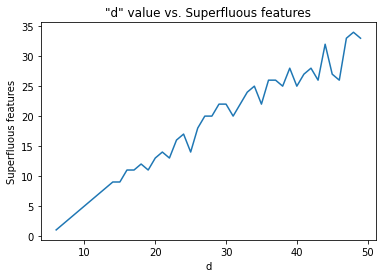

In [18]:
import matplotlib.pyplot as plt
plt.title('"d" value vs. Superfluous features')
plt.xlabel('d')
plt.ylabel('Superfluous features')
plt.plot(indices, sf_features)
plt.show()

In [19]:
def question6():
    sf_features = []
    indices = []
    for i in range(6, 50):
        indices.append(i)
        x, _, y = generate_data(10000, i)
        #print('Number of features: ', i)
        dt = DecisionTree(copy.deepcopy(x), copy.deepcopy(y), 1, 10, 1)
        sf_features.append(len(superfluous))
        superfluous.clear()
        
    plt.title('"d" value vs. Superfluous features')
    plt.xlabel('d')
    plt.ylabel('Superfluous features')
    plt.plot(indices, sf_features)
    plt.show()